### 01-Preprocessing and Quality Control

文件路径：
data/GSM6304413_EB_D0/
data/GSM6304414_iMK_D3/
data/GSM6304415_iMK_D5/
data/GSM6304416_iMK_D7/

In [29]:
import pandas as pd
import scanpy as sc
import os

# the file that will store the results
result_file = 'analysis_results.h5ad'
# the path to the input data directory
data_path = 'data'
subdata_dirs = ['GSM6304413_EB_D0', 'GSM6304414_iMK_D3', 'GSM6304415_iMK_D5', 'GSM6304416_iMK_D7']

adatas = []
for subdir in subdata_dirs:
    adata = sc.read_10x_mtx(f'{data_path}/{subdir}/', 
                            var_names='gene_symbols', 
                            cache=True)
    adata.var_names_make_unique()
    adatas.append(adata)

print(f'Loaded {len(adatas)} datasets.')

Loaded 4 datasets.


#### 文件处理
直接使用原数据出现报错，因此问了ai之后根据原有gene.mtx.gz生成feature.mtx.gz:
```bash
for d in data/*/; do if [ -f "$d/genes.tsv.gz" ]; then zcat "$d/genes.tsv.gz" | awk -F'\t' -vOFS='\t' '{print $1,$2,"Gene Expression"}' | gzip > "$d/features.tsv.gz"; echo "WROTE $d/features.tsv.gz"; else echo "MISSING $d/genes.tsv.gz"; fi; done

WROTE data/GSM6304413_EB_D0//features.tsv.gz
WROTE data/GSM6304414_iMK_D3//features.tsv.gz
WROTE data/GSM6304415_iMK_D5//features.tsv.gz
WROTE data/GSM6304416_iMK_D7//features.tsv.gz
```

### highest expressed genes (2 x 2 plot)

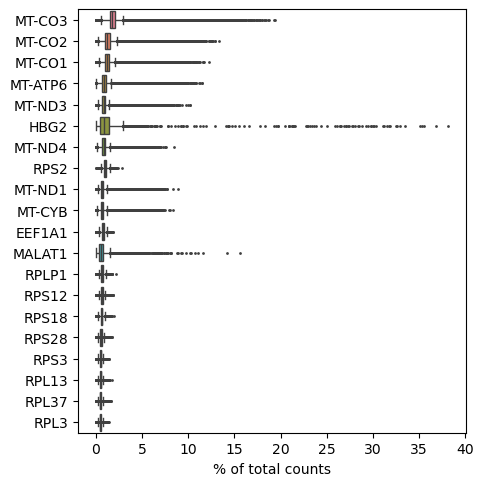

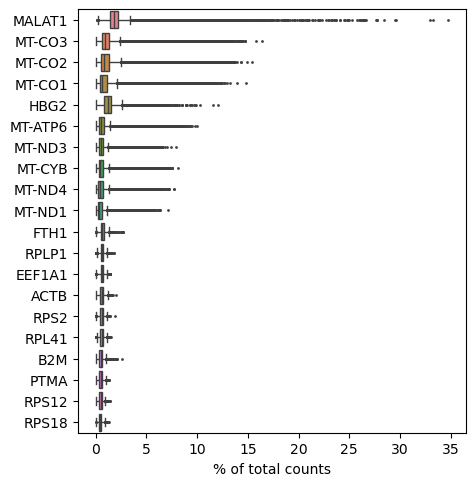

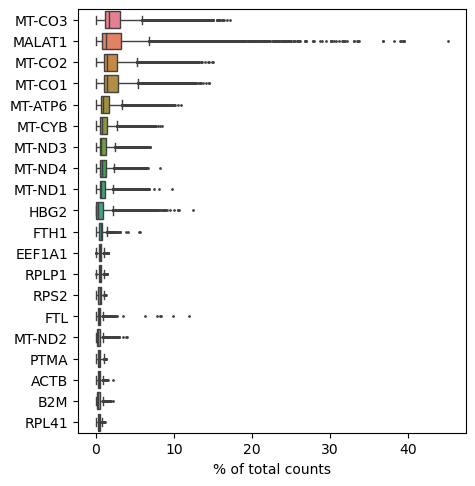

/home/wulong/micromamba/envs/scRNA_seq/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


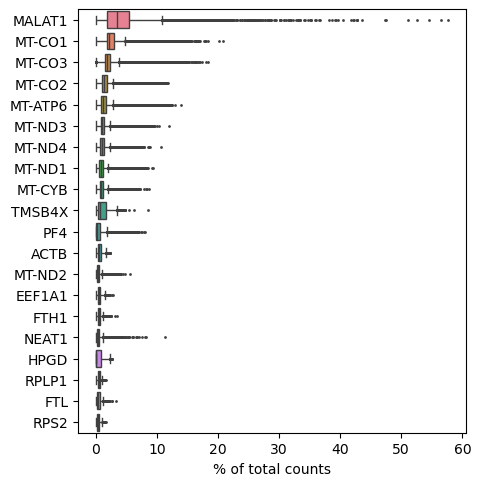

In [30]:
import matplotlib.pyplot as plt
titles = ['EB_D0', 'iMK_D3', 'iMK_D5', 'iMK_D7']
n_top = 20

# Create 2x2 subplot for highest expressed genes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, ad in enumerate(adatas):
    sc.pl.highest_expr_genes(ad, n_top=n_top, ax=axes[i], show=False)
    axes[i].set_title(titles[i])

plt.tight_layout()
plt.show()

### Cell Filtering

EB_D0: 11757 cells, 19373 genes after filtering.


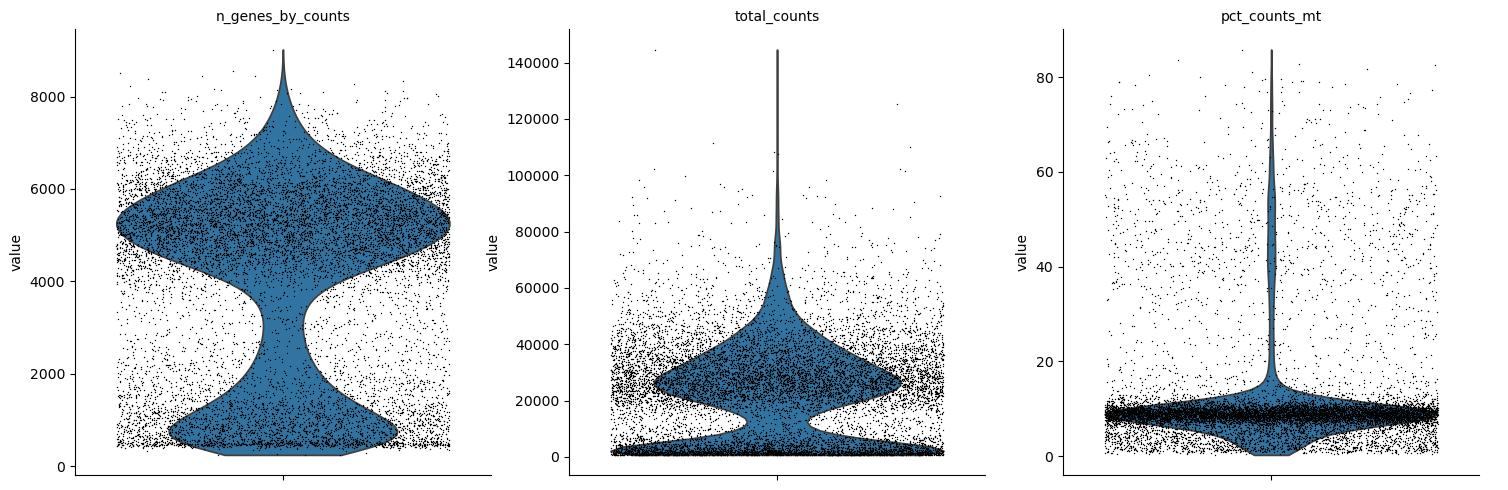

iMK_D3: 19428 cells, 19461 genes after filtering.


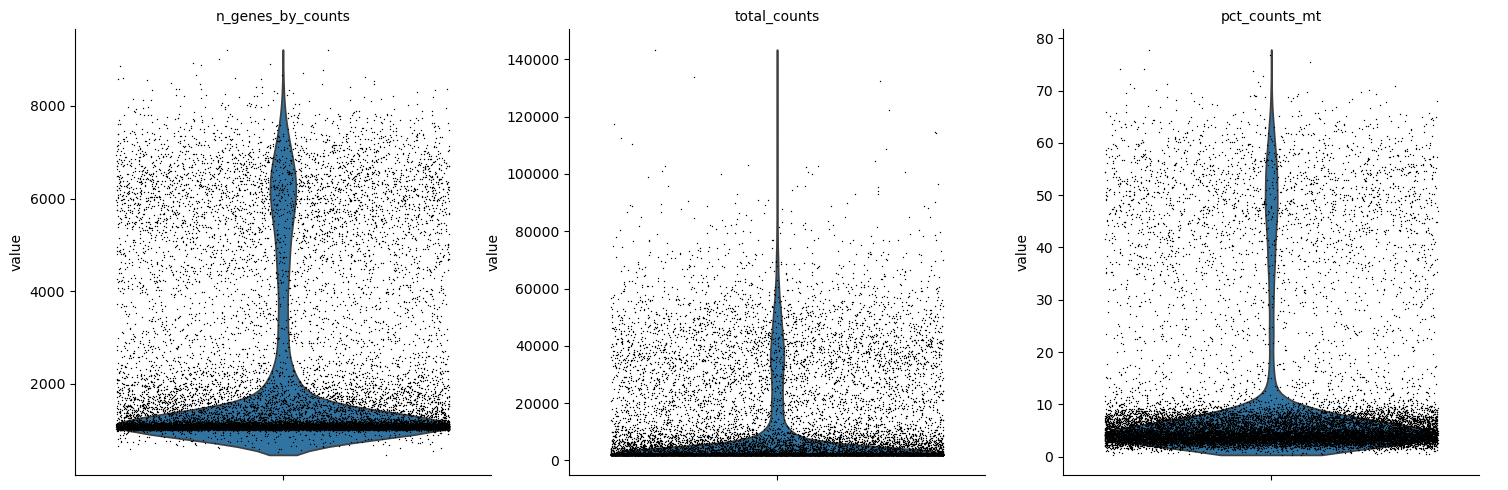

iMK_D5: 9128 cells, 19958 genes after filtering.


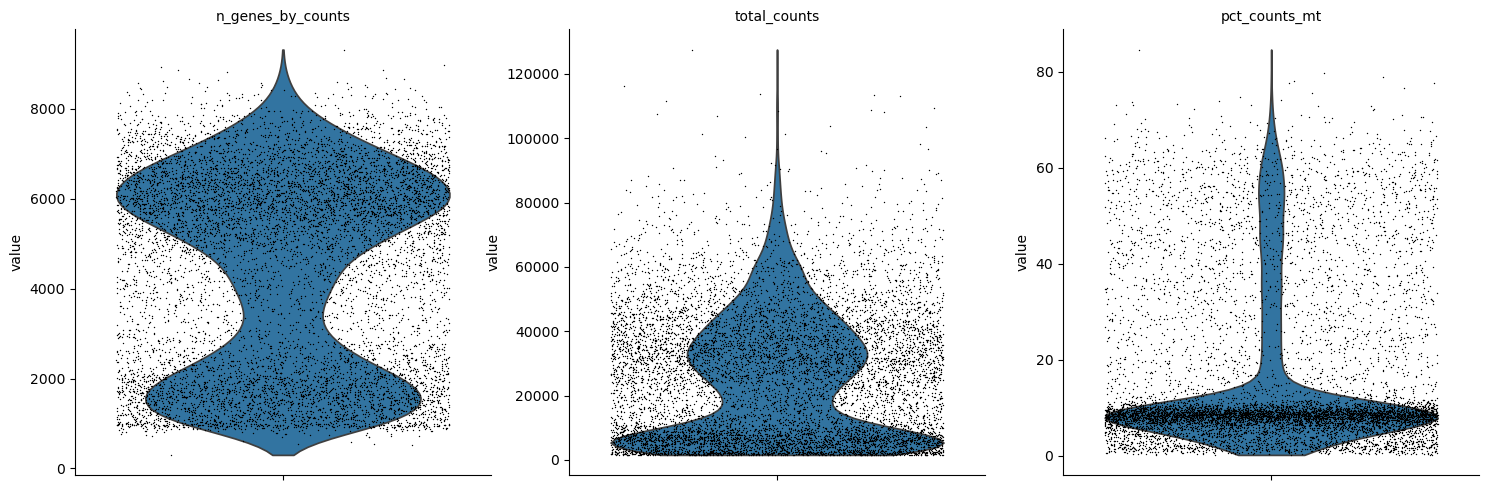

iMK_D7: 10610 cells, 19606 genes after filtering.


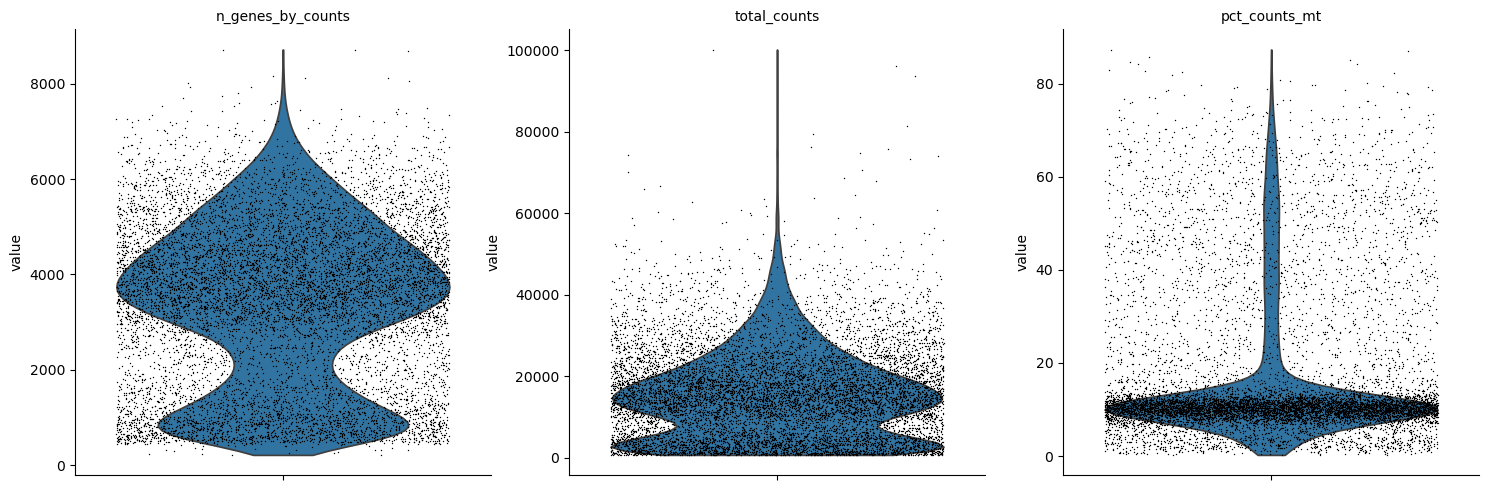

In [31]:
for i, ad in enumerate(adatas):
    sc.pp.filter_cells(ad, min_genes=200)
    sc.pp.filter_genes(ad, min_cells=3)
    print(f'{titles[i]}: {ad.n_obs} cells, {ad.n_vars} genes after filtering.')
    # annotate mitochondrial genes
    ad.var['mt'] = ad.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(
        ad, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
    )
    sc.pl.violin(
        ad,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
        jitter=0.4,
        multi_panel=True
    )

### Highly-variable genes

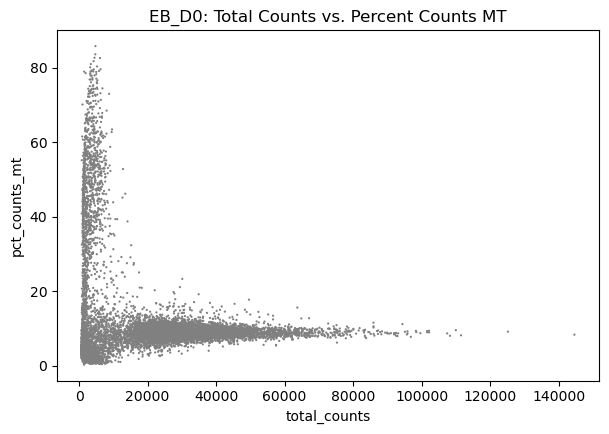

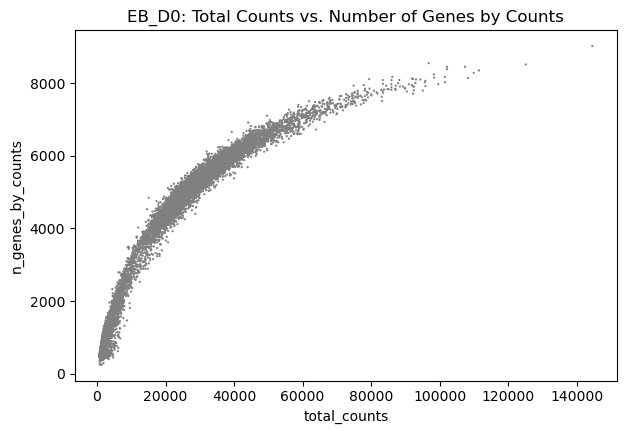

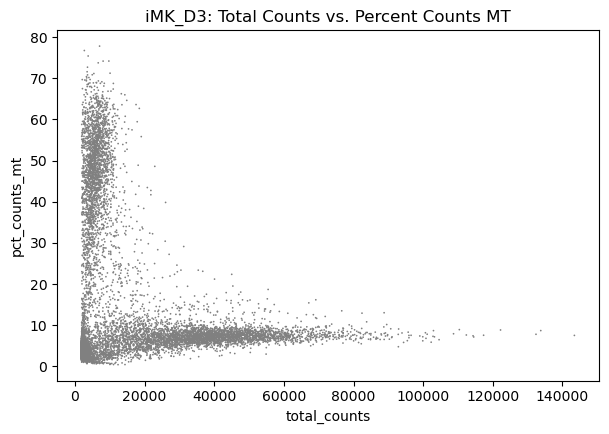

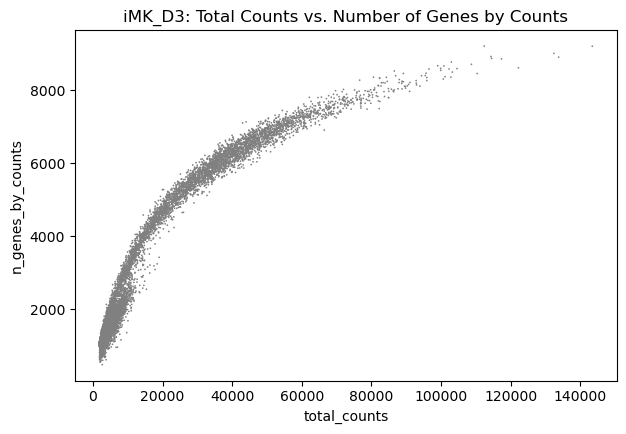

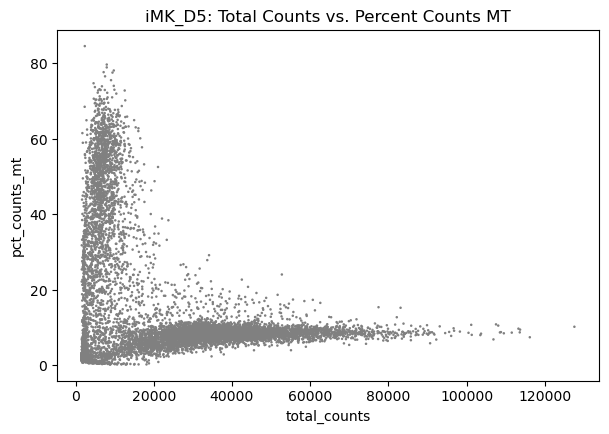

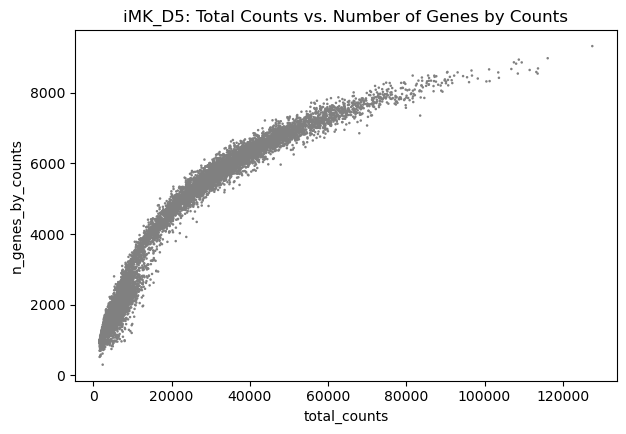

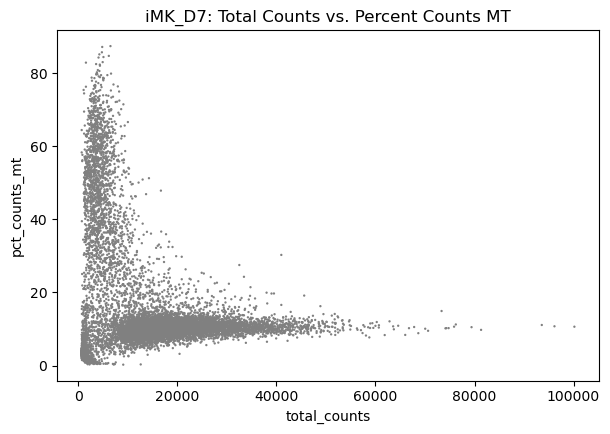

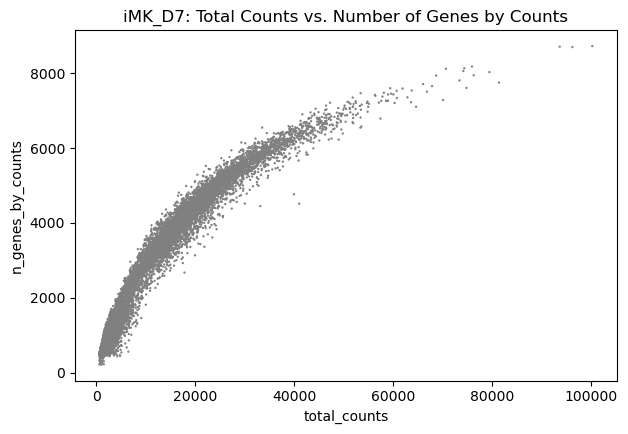

In [43]:
for i, adata in enumerate(adatas):
    figure_path = f"figures/{titles[i]}/"
    if not os.path.exists(figure_path):
        os.makedirs(figure_path)
    sc.pl.scatter(adata, 
                  x="total_counts", y="pct_counts_mt", 
                  title=f"{titles[i]}: Total Counts vs. Percent Counts MT",
                  save=f"{titles[i]}_scanpy_scatter_pct_counts_mt.png")
    sc.pl.scatter(adata, 
                  x="total_counts", y="n_genes_by_counts", 
                  title=f"{titles[i]}: Total Counts vs. Number of Genes by Counts",
                  save=f"{titles[i]}_scanpy_scatter_n_genes_by_counts.png")
    adata = adata[adata.obs.n_genes_by_counts < 2000, :]
    adata = adata[adata.obs.pct_counts_mt < 5, :].copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    #Logarithmize the data:
    sc.pp.log1p(adata)
    #Move results figure to  the corresponding directory
    os.rename(f"figures/scatter{titles[i]}_scanpy_scatter_pct_counts_mt.png", f"{figure_path}scatter_pct_counts_mt.png")
    os.rename(f"figures/scatter{titles[i]}_scanpy_scatter_n_genes_by_counts.png", f"{figure_path}scatter_n_genes_by_counts.png")